

# load data



In [0]:
try:
  # %tensorflow_version only exists in Colab.
  # শুধুমাত্র কোলাবে চেষ্টা করবো টেন্সর-ফ্লো ২.০ এর জন্য
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu

** import the data!**

**one_hot=True argument** it converts the categorical class labels to binary vectors.

In [0]:
data = input_data.read_data_sets('data/fashion',one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


# Analyze the Data

In [0]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=data.train.images.shape))
print("Training set (labels) shape: {shape}".format(shape=data.train.labels.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=data.test.images.shape))
print("Test set (labels) shape: {shape}".format(shape=data.test.labels.shape))

Training set (images) shape: (55000, 784)
Training set (labels) shape: (55000, 10)
Test set (images) shape: (10000, 784)
Test set (labels) shape: (10000, 10)


In [0]:
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

Text(0.5, 1.0, '(Label: Sneaker)')

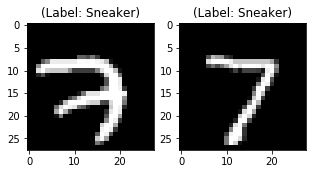

In [0]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(data.train.images[0], (28,28))
curr_lbl = np.argmax(data.train.labels[0,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(data.test.images[0], (28,28))
curr_lbl = np.argmax(data.test.labels[0,:])
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Data Preprocessing

The images are of size 28 x 28 (or a 784-dimensional vector).

In [0]:
 data.train.images[0]

In [0]:
np.max(data.train.images[0])

0.9960785

In [0]:
np.min(data.train.images[0])

0.0

**Let us reshape the images so that it's of size 28 x 28 x 1, and feed this as an input to the network.**

In [0]:
# Reshape training and testing image
train_X = data.train.images.reshape(-1, 28, 28, 1)
test_X = data.test.images.reshape(-1,28,28,1)

In [0]:
train_X.shape, test_X.shape

((55000, 28, 28, 1), (10000, 28, 28, 1))

**training and testing labels in separate variables and also print their respective shapes just be on the safer side.**

In [0]:
train_y = data.train.labels
test_y = data.test.labels

In [0]:
train_y.shape, test_y.shape

((55000, 10), (10000, 10))

# The Deep Neural Network
You'll use three convolutional layers:

The first layer will have 32-3 x 3 filters,

The second layer will have 64-3 x 3 filters and

The third layer will have 128-3 x 3 filters.

In addition, there are three max-pooling layers each of size 2 x 2.



In [0]:
training_iters = 200 
learning_rate = 0.001 
batch_size = 128

# Network Parameters

In [0]:
# MNIST data input (img shape: 28*28)
n_input = 28

# MNIST total classes (0-9 digits)
n_classes = 10

In [0]:
#both placeholders are of type float
x = tf.placeholder("float", [None, 28,28,1])
y = tf.placeholder("float", [None, n_classes])

**Creating wrappers for simplicity**

In [0]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x) 

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

In [0]:
weights = {
    'wc1': tf.get_variable('W0', shape=(3,3,1,32), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(3,3,32,64), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(3,3,64,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'wd1': tf.get_variable('W3', shape=(4*4*128,128), initializer=tf.contrib.layers.xavier_initializer()), 
    'out': tf.get_variable('W6', shape=(128,n_classes), initializer=tf.contrib.layers.xavier_initializer()), 
}
biases = {
    'bc1': tf.get_variable('B0', shape=(32), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(64), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'bd1': tf.get_variable('B3', shape=(128), initializer=tf.contrib.layers.xavier_initializer()),
    'out': tf.get_variable('B4', shape=(10), initializer=tf.contrib.layers.xavier_initializer()),
}

In [0]:
def conv_net(x, weights, biases):  

    # here we call the conv2d function we had defined above and pass the input image x, weights wc1 and bias bc1.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    # here we call the conv2d function we had defined above and pass the input image x, weights wc2 and bias bc2.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 7*7 matrix.
    conv2 = maxpool2d(conv2, k=2)

    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 4*4.
    conv3 = maxpool2d(conv3, k=2)


    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Output, class prediction
    # finally we multiply the fully connected layer with the weights and add a bias term. 
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# Loss and Optimizer Nodes

**conv_net()** function by passing in input **x**, **weights** and **biases**

label **y**. You will then take the mean (**reduce_mean**) over all the batches to get a **single loss/cost value.**

**optimizer** specify the learning rate with explicitly stating **minimize cost **that you had **calculated** in the previous step.

In [0]:
pred = conv_net(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Evaluate Model Node

In [0]:
#Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

#calculate accuracy across all the given images and average them out. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
# Initializing the variables
init = tf.global_variables_initializer()

# Training and Testing the Model

In [0]:
with tf.Session() as sess:
    sess.run(init) 
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    summary_writer = tf.summary.FileWriter('./Output', sess.graph)
    for i in range(training_iters):
        for batch in range(len(train_X)//batch_size):
            batch_x = train_X[batch*batch_size:min((batch+1)*batch_size,len(train_X))]
            batch_y = train_y[batch*batch_size:min((batch+1)*batch_size,len(train_y))]    
            # Run optimization op (backprop).
                # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                              y: batch_y})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y})
        print("Iter " + str(i) + ", Loss= " + \
                      "{:.6f}".format(loss) + ", Training Accuracy= " + \
                      "{:.5f}".format(acc))
        print("Optimization Finished!")

        # Calculate accuracy for all 10000 mnist test images
        test_acc,valid_loss = sess.run([accuracy,cost], feed_dict={x: test_X,y : test_y})
        train_loss.append(loss)
        test_loss.append(valid_loss)
        train_accuracy.append(acc)
        test_accuracy.append(test_acc)
        print("Testing Accuracy:","{:.5f}".format(test_acc))
    summary_writer.close()

Iter 0, Loss= 0.022127, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.96520
Iter 1, Loss= 0.004514, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98540
Iter 2, Loss= 0.004382, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98670
Iter 3, Loss= 0.002093, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98810
Iter 4, Loss= 0.001003, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98750
Iter 5, Loss= 0.000890, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98710
Iter 6, Loss= 0.001663, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98700
Iter 7, Loss= 0.010365, Training Accuracy= 0.99219
Optimization Finished!
Testing Accuracy: 0.98720
Iter 8, Loss= 0.000306, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98670
Iter 9, Loss= 0.000610, Training Accuracy= 1.00000
Optimization Finished!
Testing Accuracy: 0.98740


In [0]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(train_loss)), test_loss, 'r', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()

In [0]:
plt.plot(range(len(train_loss)), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(len(train_loss)), test_accuracy, 'r', label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()
plt.figure()
plt.show()